# Tree species classification

We use the `<VIRASS.TreeSpeciesClassifier>` class to build a deep-learning based tree species classifier model.

The approach described here refers to the following paper:

- M. Gazzea, L. M. Kristensen, F. Pirotti, E. E. Ozguven and R. Arghandeh, "Tree Species Classification Using High-Resolution Satellite Imagery and Weakly Supervised Learning," in IEEE Transactions on Geoscience and Remote Sensing, vol. 60, pp. 1-11, 2022, Art no. 4414311, doi: 10.1109/TGRS.2022.3210275.

[![10.1109/TGRS.2022.3210275](http://img.shields.io/badge/DOI-10.1101/2021.01.08.425840-B31B1B.svg)](https://ieeexplore.ieee.org/abstract/document/9905623)



## Basic usage

We load the *VIRASS* library, which implements all the necessary steps. 
We recall that the necessary input data are:
- a satellite image
- a binary tree mask (obtained externally or using the `<VIRASS.TreeSegmenter>`, check the relative [Jupyter notebook](/Block_tree_segmentation.ipynb)).
- a general tree inventory. This is a dataset that classifies forest stands as species. In our case for Norway, this is provided by [NIBIO skogportalen](https://kilden.nibio.no/?topic=arealinformasjon&zoom=0&x=7191285.04&y=284337.75&bgLayer=graatone). In general, almost all countries have similar forest inventories. The image below shows an exaple of this tree inventory.

<img src="images/tree_species/NIBIO_with_legend.png" width="600">

In [2]:
# Import the VIRASS library
import ASPIREv as ges
   
# Load Satellite image 
SAT_image, meta_data = ges.io.open_geoTiFF("_data/WorldView_area.tif")  

# Load the NIBIO dataset
R_ref = ges.io.open_geoTiFF("_data/trees/tree_species/NIBIO.tif", with_meta_data = False)

# Load binary tree_mask
tree_mask_bn  = ges.io.open_geoTiFF("_data/trees/tree_segmentation/tree_mask_bn_1_2.tif", with_meta_data = False)

Converting to channel_last:
(8, 9023, 12914)
--> (9023, 12914, 8)
Converting to channel_last:
(1, 9023, 12914)
--> (9023, 12914, 1)
Converting to channel_last:
(1, 9023, 12914)
--> (9023, 12914, 1)


### Initialization 
We initialize the `TreeSpeciesClassifier` class. The behaviour of the class is controlled by the YAML config file provided as input file to the class.

In [3]:
tree_species_classifier = ges.tree_species_classification.TreeSpeciesClassifier(config_file = "tree_species_classifier_config.yaml")
tree_species_classifier.print_attributes()


***class <TreeSpeciesClassifier> initialized ***


---Printing class attributes:---
X_map = None
y_map = None
meta_data = None
DLmodel = None
patch_radius = 0
working_dir = C:/Users/miche/Dropbox/PhD/Projects/GridEyeS/PWD_2/VIRASS/_data/trees/tree_species/\
config = {'config_AE': {'autoencoder_name': 'AE_2', 'encoder_name': 'E_2', 'method': 'ae'}, 'config_relabeling': {'plot_uMAP': True, 'number_patches': {'deciduous': 1000, 'pines': 1000, 'spruces': 1000}, 'radius_patch': 6, 'tree_types_legend': {'deciduous': 5, 'pines': 2, 'spruces': 1}, 'n_cluster': 20}, 'config_training': {'architecture': 'unet', 'patch_number': 20000, 'patch_radius': 40, 'model_name': 'Unet_species_2', 'n_epochs': 200, 'lr': 0.001}}




### Relabelling process

The tree inventory labels are often noisy or missing. The relabelling process consists of extracting features sampled from different forest stands and analyze the features in the feature space. A semantic constraint is develop such that features close to each other in the feature space have the same label (i.e., tree specie). The features exctraction is done using an autoencoder.  
See the related paper for technical details.

Pre process NIBIO dataset
Create baseline
Time for extract_patches_from_baseline is 3.300386905670166
***
class <FeatureExtractor> initialized ***

Tree patches: (3000, 12, 12, 8)
Extracting features via autoencoders
Input shape:  (12, 12, 8)
***class <Autoencoder> initialized ***

-- Loading existing autoencoder
--autoencoder and encoder loaded
94/94 [==============================] - 0s 1ms/step
Time for compute_features_AE is 0.5055077075958252
--Semantic costraint
--Relabeling over the entire area
Tree patches: (808076, 12, 12, 8)
Extracting features via autoencoders
Input shape:  (12, 12, 8)
***class <Autoencoder> initialized ***

-- Loading existing autoencoder
--autoencoder and encoder loaded
25253/25253 [==============================] - 29s 1ms/step
Time for compute_features_AE is 42.89626598358154


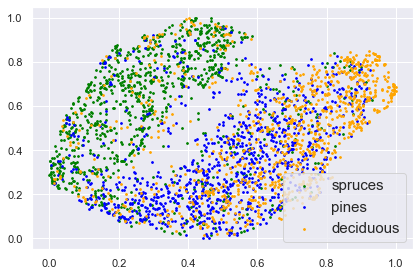

In [9]:
# Relabeling process
R_relabeled = tree_species_classifier.relabeling(R_ref, tree_mask_bn, SAT_image, meta_data)

The figure above shows the [UMAP](https://umap-learn.readthedocs.io/en/latest/) plot of the feature space mapped into into $\mathbb{R}^2$. The feature space is generated by the following autoencoder:

<img src="docs/DL_architectures/AE.png" width="600">

Converting to first:
(9023, 12914, 1)
--> (1, 9023, 12914)


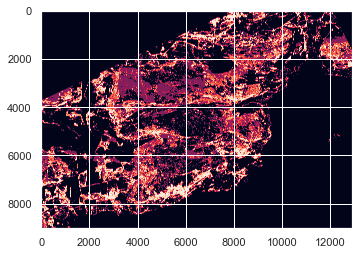

In [10]:
ges.io.export_GEOtiff(tree_species_classifier.working_dir + "R_relabeled_2.tif", R_relabeled, meta_data)
import matplotlib.pyplot as plt
plt.imshow(R_relabeled)

### Deep learning training

Once we perform the relabelling process, we train a deep learning model in a standard way. This way the model can be used standalone without relabelling again.

In [4]:
# Training process 
tree_species_classifier.load_X_map("_data/WorldView_area.tif")
tree_species_classifier.load_y_map("_data/trees/tree_species/R_relabeled_2.tif")
tree_species_classifier.build_model()


 Loading X_map
Converting to channel_last:
(8, 9023, 12914)
--> (9023, 12914, 8)
X_map shape:(9023, 12914, 8)
X_map loaded 


 Loading y_map
Converting to channel_last:
(1, 9023, 12914)
--> (9023, 12914, 1)
Ground truth shape:(9023, 12914, 1)
y_map loaded 

--Model loaded


Predict over the entire area and export it as geoTiFF:

In [ ]:
# Prediction over the whole area
tree_species_map_pred = tree_species_classifier.generate_tree_species_map(SAT_image)

# tree_species_map_quantized = tree_species_classifier.quantize_tree_species_map(tree_species_map_pred)
ges.io.export_GEOtiff("_data/trees/tree_species/R_refined_2.tif", tree_species_map_pred, meta_data)